In [14]:
import sys, os

# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *
from lifelines import KaplanMeierFitter, CoxPHFitter
import math

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


In [15]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    # Create a copy of y to work on
    y_out = y.clone()  # or copy.deepcopy(y) if you prefer
    # Create an event indicator: 1 where y > 0, else 0.
    event_indicator = (y_out > 0).float()
    # Compute the cumulative sum along the time dimension.
    c = torch.cumsum(event_indicator, dim=1)
    # Shift the cumulative sum one time step to the right.
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    # Create a mask that is True for time steps after the first event (i.e., where c_shifted > 0)
    mask = (c_shifted > 0)
    # Mask the y_out values after the first event.
    y_out[mask] = missing_to_num

    # If neither x nor z is provided, return only y_out.
    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  # infer number of observations and timesteps from y

    # Process x if provided.
    x_out = None
    if x is not None:
        # Reshape to (n_obs, timesteps, x_dim)
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        # Expand mask to cover the x_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        # Apply the mask to x_out.
        x_out[mask_expanded] = missing_to_num
        # Reshape x_out back to its original shape.
        x_out = x_out.view(n_obs, timesteps * x_dim)

    # Process z if provided.
    z_out = None
    if z is not None:

        # Reshape to (n_obs, timesteps, z_dim)
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        # Expand mask to cover the z_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        # Apply the mask to z_out.
        z_out[mask_expanded] = missing_to_num
        # Reshape z_out back to its original shape.
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out


def long_to_surv(y):
    num_individuals, num_time_points = y.shape
    times = []
    events = []

    for i in range(num_individuals):
        individual = y[i].tolist()
        try:
            # Find the index of the first event (1)
            event_time = individual.index(1) + 1  # +1 if time starts at 1
            event = 1
        except ValueError:
            # If no event occurred, censor at the last time point
            event_time = num_time_points
            event = 0
        
        times.append(event_time)
        events.append(event)

    df = pd.DataFrame({
        'time': times,
        'event': events,
    })
    return df
def plot_survival_time_distribution(df_ground_truth, df_estimate, x_value):
    """
    Plots the distribution of survival times for Ground Truth and FR Estimate.

    Parameters:
    - df_ground_truth: DataFrame containing 'time' for Ground Truth.
    - df_estimate: DataFrame containing 'time' for FR Estimate.
    - x_value: The value of x (0 or 1) being plotted.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot Ground Truth Distribution
    sns.kdeplot(data=df_ground_truth, x='time', fill=True, color='blue', label='Ground Truth', alpha=0.5)
    
    # Plot FR Estimate Distribution
    sns.kdeplot(data=df_estimate, x='time', fill=True, color='green', label='FR Estimate', alpha=0.5)
    
    # Customize the plot
    plt.title(f'Survival Time Distribution for x={x_value}')
    plt.xlabel('Time')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
s,x,z,y = generate_data_survivl(n=10000,T=10, random_seed=42, C_coeff=0.1, setting = 1)

In [4]:
y

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 1., nan, nan, ..., nan, nan, nan],
       [ 0.,  1., nan, ..., nan, nan, nan],
       [ 1., nan, nan, ..., nan, nan, nan]])

In [28]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting = 2)
s_tr = torch.tensor(s, dtype=torch.float32)
s_tr = torch.cat([s_tr,s_tr,s_tr], dim=1)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))
z_tr = torch.cat([z_tr,z_tr,z_tr], dim=1)

model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=10, s_dim = 3, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
# model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1500, lr=1e-4, print_every_iter=500)

In [29]:
s_tr.shape

torch.Size([5000, 3])

In [30]:
s_tr

tensor([[1.8245, 1.8245, 1.8245],
        [0.4441, 0.4441, 0.4441],
        [0.7796, 0.7796, 0.7796],
        ...,
        [0.1816, 0.1816, 0.1816],
        [0.7424, 0.7424, 0.7424],
        [1.8149, 1.8149, 1.8149]])

In [31]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=3500, lr=1e-4, print_every_iter=500, reg_lambda=0)

Epoch 1: loss 4.5350,	loss_y 1.5735, 1.5891, 0.0311,	loss_eta 2.9615, 3.0915, 0.2600, 	marginal_loss 2.3456
Epoch 500: loss 3.0251,	loss_y 0.8357, 1.4494, 1.2274,	loss_eta 2.1894, 4.4743, 4.5699, 	marginal_loss 8.5366
Epoch 1000: loss 2.4142,	loss_y 0.2043, 0.3685, 0.3284,	loss_eta 2.2099, 4.6163, 4.8129, 	marginal_loss 8.5732
Epoch 1500: loss 2.2266,	loss_y 0.0599, 0.1080, 0.0961,	loss_eta 2.1667, 4.4300, 4.5266, 	marginal_loss 8.5516
Epoch 2000: loss 2.2075,	loss_y 0.0379, 0.0653, 0.0549,	loss_eta 2.1696, 4.3760, 4.4127, 	marginal_loss 8.4644
Epoch 2500: loss 2.1940,	loss_y 0.0223, 0.0392, 0.0339,	loss_eta 2.1717, 4.3586, 4.3738, 	marginal_loss 8.5754
Epoch 3000: loss 2.2005,	loss_y 0.0186, 0.0285, 0.0199,	loss_eta 2.1819, 4.3573, 4.3508, 	marginal_loss 8.4740
Epoch 3500: loss 2.1954,	loss_y 0.0110, 0.0177, 0.0136,	loss_eta 2.1844, 4.3543, 4.3397, 	marginal_loss 8.5138


In [6]:
model.train_xz(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=500, lr=1e-4, print_every_iter=500)

Epoch 1: loss 5.6280, loss1 5.7628, loss2 0.2697
Epoch 500: loss 1.6123, loss1 3.2493, loss2 3.2740


In [10]:
y_tr.float().mean()

tensor(0.0994)

In [7]:
x_pred,z_pred,y_pred = model.sample_joint(s=s_tr)

In [8]:
z_pred

tensor([[ 0.0268,  0.7909, -0.0926,  ..., -0.0074, -0.0312, -0.0202],
        [-0.1583,  1.3226,  0.2001,  ...,  0.9678, -0.7708, -1.2408],
        [-1.4230, -0.4221,  0.2756,  ...,  0.2682,  0.5060,  0.6730],
        ...,
        [-0.7754,  2.4505,  2.1209,  ...,  1.3085,  0.9963,  0.5368],
        [ 0.1134,  0.2692,  0.8776,  ...,  0.8968,  1.0125, -0.3853],
        [-0.0696, -0.2200, -0.2644,  ..., -0.6670,  0.3928, -0.2080]])

In [9]:
z_tr

tensor([[ 0.1865,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2532,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5645,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8464,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3038,  0.9819,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3758, -0.7267,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [10]:
x_tr

tensor([[3.3115,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.0468,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.4541,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [2.9632,    nan,    nan,  ...,    nan,    nan,    nan],
        [2.7814, 3.5375,    nan,  ...,    nan,    nan,    nan],
        [1.2831, 1.3278,    nan,  ...,    nan,    nan,    nan]])

In [11]:
z_tr

tensor([[ 0.1865,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2532,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5645,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8464,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3038,  0.9819,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3758, -0.7267,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [45]:
z_pred

tensor([[-0.9819,  1.2784,  1.9162,  ..., -0.4180, -1.2131, -0.3144],
        [ 0.0603,  1.3026,  1.4995,  ..., -1.5490,  0.6302,  1.7578],
        [-1.2773,  0.7588,  1.7736,  ...,  0.9755,  0.1301,  1.1783],
        ...,
        [ 0.1599,  1.6337,  1.2500,  ..., -0.9316, -0.9987,  1.8018],
        [-0.9929,  1.6236,  0.6103,  ..., -0.2167,  2.5586,  0.6828],
        [-0.2133,  0.6129,  0.1418,  ..., -0.2232, -0.8498, -0.2698]])

In [12]:
missing_impute(y=y_pred, x=x_pred, z=z_pred)

(tensor([[ 2.9668, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.8140, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.8477,  3.6335,  2.8324,  ...,  1.3323,  1.4639,  0.7282],
         ...,
         [ 2.4107,  1.7551,  2.4000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.9989,  2.7739,  2.7278,  ...,  1.7596,  1.9774,  1.9177],
         [ 1.2901, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 0.0268, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2929, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.3784,  1.4478,  2.0247,  ..., -0.6000,  0.7429,  0.9350],
         ...,
         [-1.0241,  1.0622,  1.3402,  ..., -1.0000, -1.0000, -1.0000],
         [-0.1002,  1.6303,  0.9692,  ...,  2.7253,  0.5674,  0.9988],
         [-1.5497, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 1., -1., -1.,  ..., -1., -1., -1.],
         [ 1., -1., -1.,  ..., -1., -1., -1.],
         [ 0.,  0.,  0

In [57]:
missing_impute(y=y_tr, x=x_tr, z=z_tr)

(tensor([[ 3.3115, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 3.0468, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.4541, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 2.9632, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 2.7814,  3.5375, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.2831,  1.3278, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 0.1865, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.2532, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.5645, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8464, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.3038,  0.9819, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.3758, -0.7267, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]),
 tensor([[ 1, -1, -1,  ..., -1, -1, -1],
         [ 1, -1, -1,  ..., -1, -1, -1],
         [ 1, -1, -1,  ..., -1, -1

In [39]:
x_pred

tensor([[2.7132, 4.0375, 3.2200,  ..., 2.3892, 2.6599, 3.4138],
        [2.8578, 3.0699, 2.7401,  ..., 2.3323, 2.0439, 2.7395],
        [1.0744, 0.9953, 1.2246,  ..., 1.1275, 1.0019, 1.1448],
        ...,
        [2.6034, 3.5294, 2.9835,  ..., 2.2102, 1.8448, 2.3789],
        [2.7689, 3.2979, 3.1178,  ..., 2.0721, 2.5408, 2.1633],
        [1.1935, 1.2304, 1.3721,  ..., 1.3837, 1.1643, 0.5770]])

## Setting 1

In [68]:
s,x,z,y = generate_data_survivl(n=10000,T=5, random_seed=42, C_coeff=0.1, setting = 1)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model1 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model1.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=2000, lr=1e-4, print_every_iter=500)

Epoch 1: loss 3.1756,	loss_y 1.1123, 1.1206, 0.0165,	loss_eta 2.0633, 2.1345, 0.1423, 	marginal_loss 0.3715
Epoch 1: y_sample_mean 0.35354000329971313
Epoch 1: y_sample1_cat.float().mean() 0.5017409920692444
Epoch 500: loss 2.2342,	loss_y 0.7210, 1.2464, 1.0509,	loss_eta 1.5132, 3.0259, 3.0254, 	marginal_loss 0.0095
Epoch 500: y_sample_mean 0.35085999965667725
Epoch 500: y_sample1_cat.float().mean() 0.3742547631263733
Epoch 1000: loss 2.1793,	loss_y 0.6810, 1.2697, 1.1772,	loss_eta 1.4982, 3.0084, 3.0203, 	marginal_loss 0.0027
Epoch 1000: y_sample_mean 0.3521600067615509
Epoch 1000: y_sample1_cat.float().mean() 0.3609025776386261
Epoch 1500: loss 2.1880,	loss_y 0.6697, 1.2793, 1.2192,	loss_eta 1.5183, 3.0115, 2.9863, 	marginal_loss 0.0007
Epoch 1500: y_sample_mean 0.35572001338005066
Epoch 1500: y_sample1_cat.float().mean() 0.3577052056789398
Epoch 2000: loss 2.1715,	loss_y 0.6633, 1.2808, 1.2351,	loss_eta 1.5082, 2.9987, 2.9809, 	marginal_loss 0.0005
Epoch 2000: y_sample_mean 0.351579

In [78]:

# torch.manual_seed(42)
C=0

y_x1 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*5],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 5)                                            
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*5],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 5)     
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(5) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

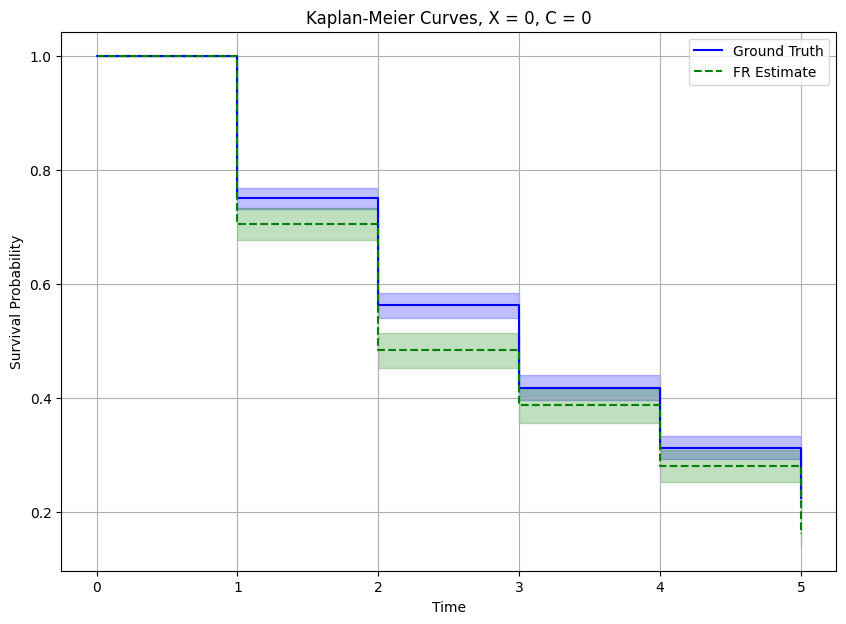

In [79]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [80]:
# y_x1 is shape (1000,5)
# 1) compute a boolean mask of rows that contain at least one 1
has_event = (y_x1.sum(dim=1) > 0)

# 2) convert to float and average
prop_at_least_one = has_event.float().mean().item()

print(f"Proportion of rows with ≥1 event: {prop_at_least_one:.3f}")


Proportion of rows with ≥1 event: 0.923


In [81]:
# y_x1 is shape (1000,5)
# 1) compute a boolean mask of rows that contain at least one 1
has_event = (y_x0.sum(dim=1) > 0)

# 2) convert to float and average
prop_at_least_one = has_event.float().mean().item()

print(f"Proportion of rows with ≥1 event: {prop_at_least_one:.3f}")


Proportion of rows with ≥1 event: 0.838


In [96]:

# torch.manual_seed(42)
C=1

y_x1 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*5],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 5)                                            
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*5],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 5)     
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(5) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

In [97]:
# y_x1 is shape (1000,5)
# 1) compute a boolean mask of rows that contain at least one 1
has_event = (y_x1.sum(dim=1) > 0)

# 2) convert to float and average
prop_at_least_one = has_event.float().mean().item()

print(f"Proportion of rows with ≥1 event: {prop_at_least_one:.3f}")


Proportion of rows with ≥1 event: 0.931


In [98]:
# y_x1 is shape (1000,5)
# 1) compute a boolean mask of rows that contain at least one 1
has_event = (y_x0.sum(dim=1) > 0)

# 2) convert to float and average
prop_at_least_one = has_event.float().mean().item()

print(f"Proportion of rows with ≥1 event: {prop_at_least_one:.3f}")


Proportion of rows with ≥1 event: 0.888


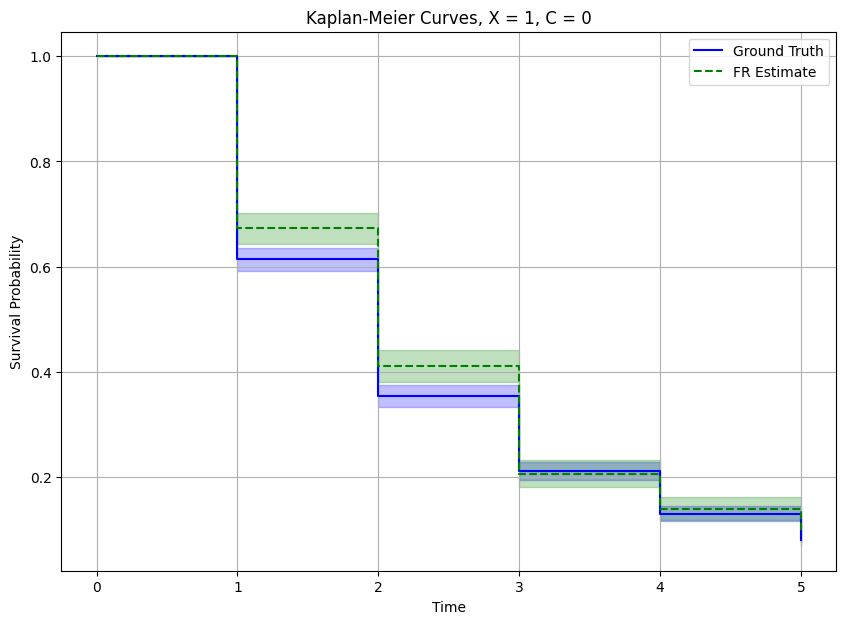

In [71]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

# torch.manual_seed(42)
C=1

y_x1 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)  
df_x1 = long_to_surv(y_x1)

y_x0 = missing_impute(model1.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)  
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.3+0.1*C  # mean parameter
mu_x1 = 0.5+0.1*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time+1 , time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

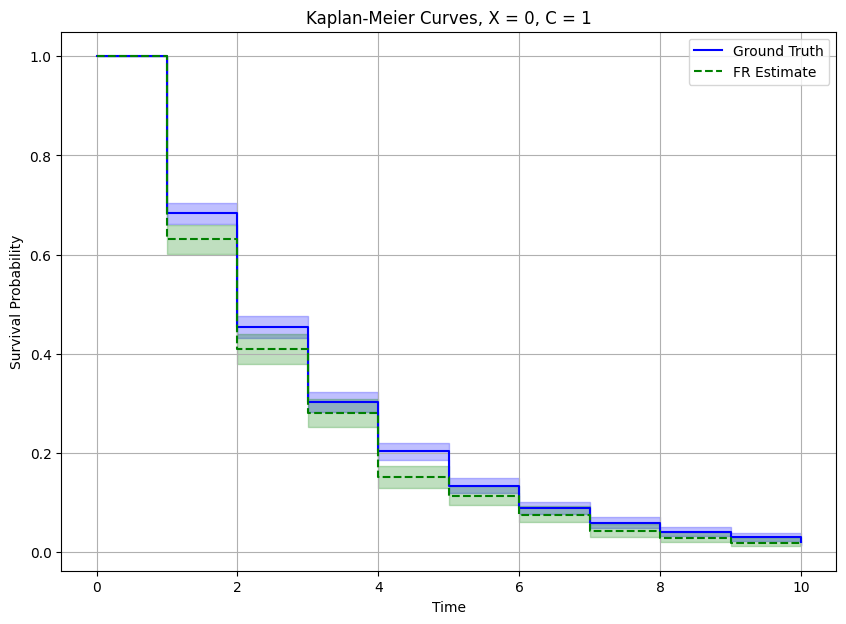

In [19]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

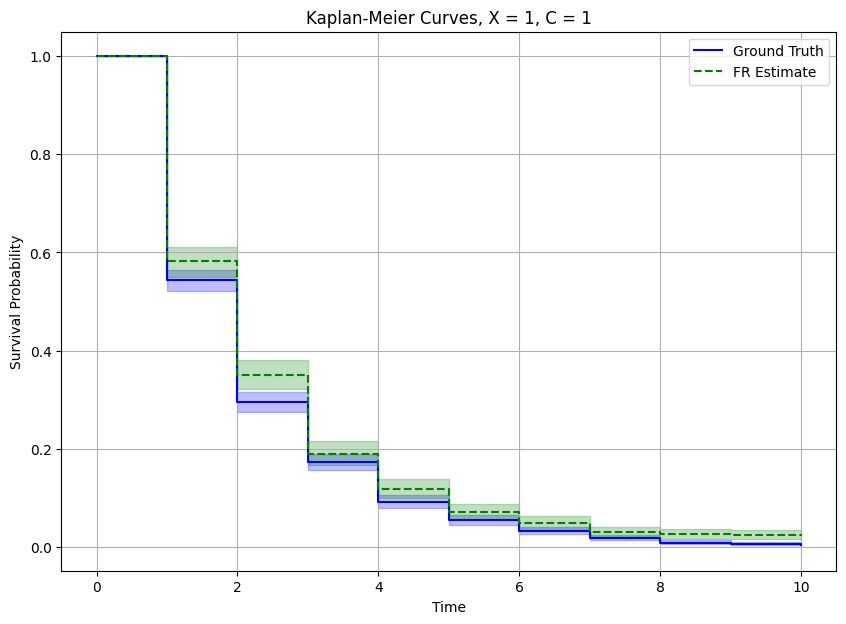

In [20]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

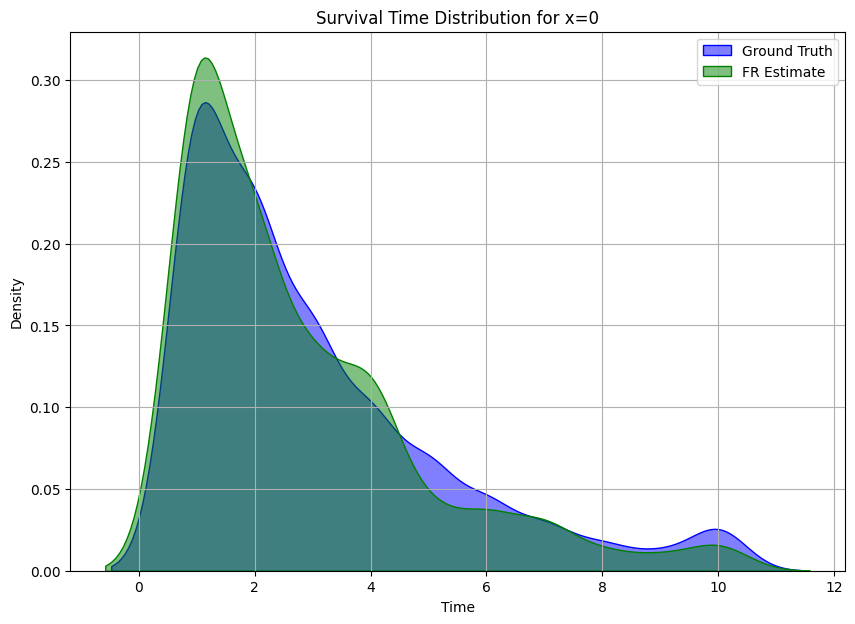

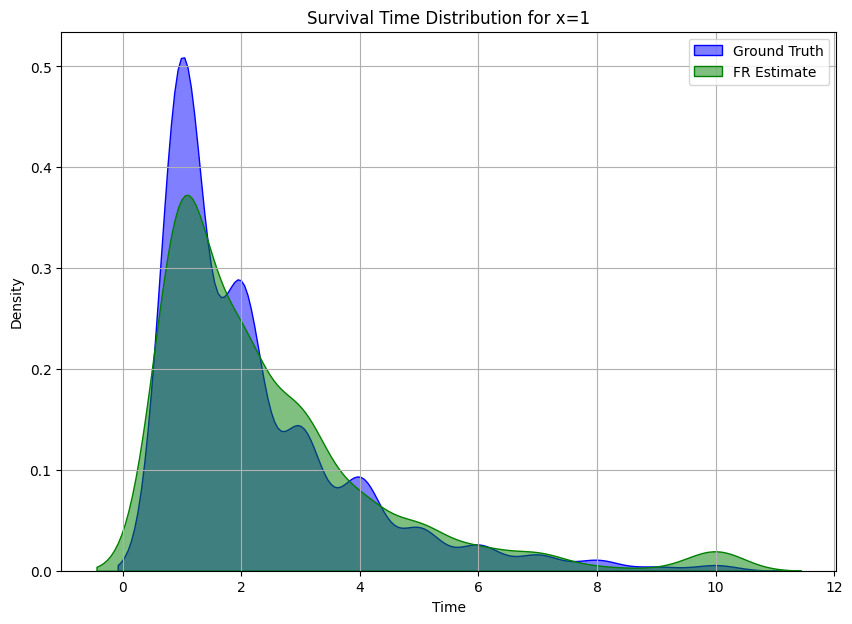

In [21]:
# Distribution for x=0
plot_survival_time_distribution(df_ground_truth=df_binary_x0,
                                df_estimate=df_x0,
                                x_value=0)

# Distribution for x=1
plot_survival_time_distribution(df_ground_truth=df_binary_x1,
                                df_estimate=df_x1,
                                x_value=1)


# Setting 2

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=2025, C_coeff=0.2, setting = 2)
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model2 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model2.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1200, lr=1e-4, print_every_iter=500)

Epoch 1: loss 4.5041,	loss_y 1.5641, 1.5804, 0.0325,	loss_eta 2.9400, 3.1169, 0.3537
Epoch 500: loss 3.0819,	loss_y 0.9218, 1.5782, 1.3128,	loss_eta 2.1601, 4.3681, 4.4160
Epoch 1000: loss 2.9610,	loss_y 0.7969, 1.4525, 1.3112,	loss_eta 2.1641, 4.3440, 4.3598


In [ ]:

C=0

y_x1 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.float32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 1000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

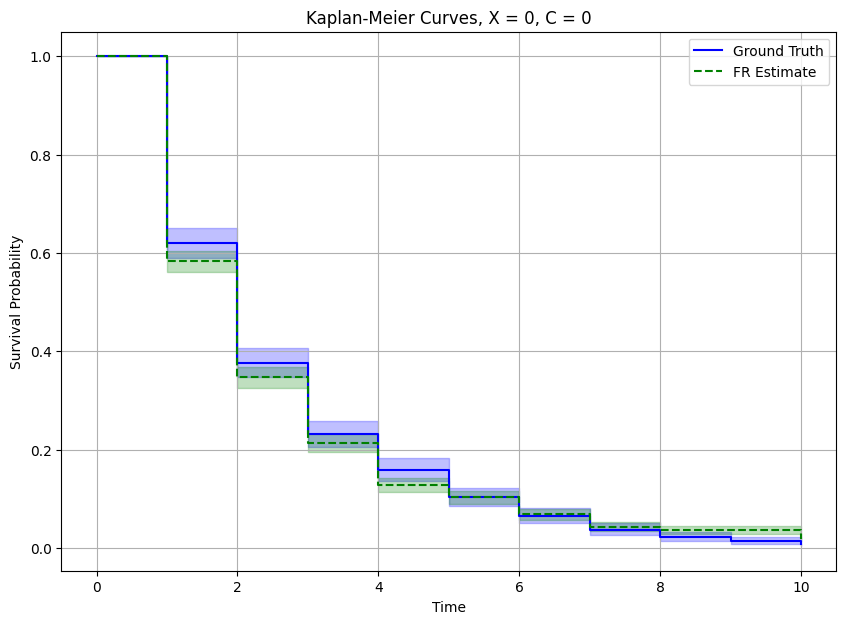

In [51]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

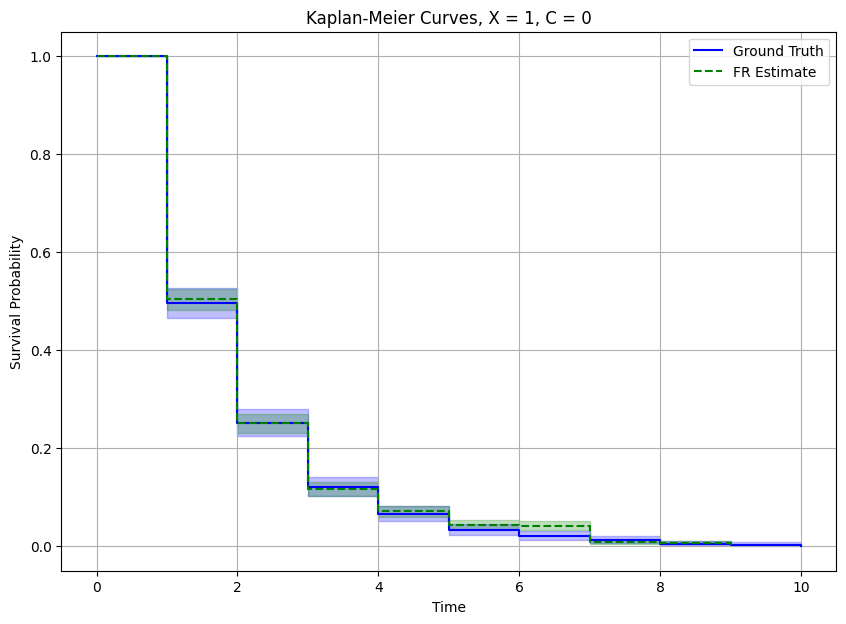

In [52]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

torch.manual_seed(42)
C=1

y_x1 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*10],dtype=torch.int32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)                                            
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model2.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.float32), 
                                            x = torch.tensor([[0]*10],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.5+0.2*C  # mean parameter
mu_x1 = 0.7+0.2*C
phi=1

n_samples = 2000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

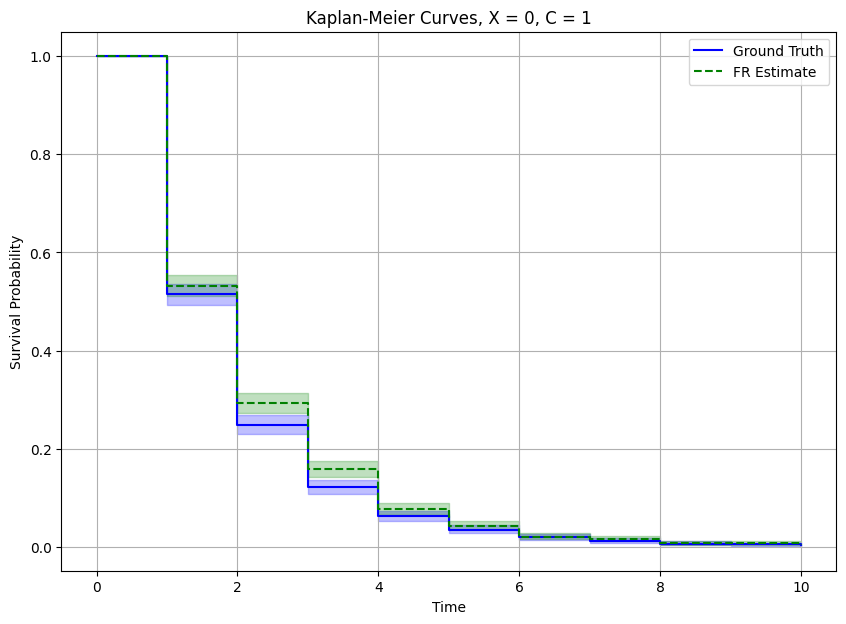

In [54]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

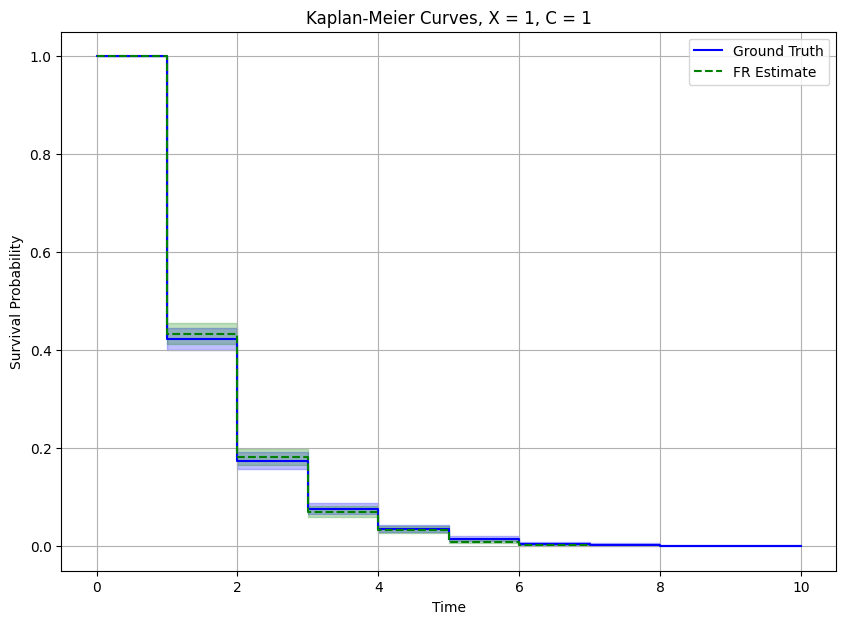

In [55]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 3

In [ ]:
s,x,z,y = generate_data_survivl(n=5000,T=12, random_seed=2025, C_coeff=0.1, setting=3)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model3 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=12, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model3.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1400, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.9786,	loss_y 1.7211, 1.7380, 0.0337,	loss_eta 3.2575, 3.3859, 0.2568
Epoch 200: loss 3.6172,	loss_y 1.2009, 1.4347, 0.4676,	loss_eta 2.4163, 4.4472, 4.0618
Epoch 400: loss 3.4703,	loss_y 1.0704, 1.4997, 0.8586,	loss_eta 2.3999, 4.8193, 4.8388
Epoch 600: loss 3.3920,	loss_y 0.9843, 1.5746, 1.1807,	loss_eta 2.4077, 4.8208, 4.8262
Epoch 800: loss 3.3581,	loss_y 0.9525, 1.6252, 1.3454,	loss_eta 2.4056, 4.7982, 4.7852
Epoch 1000: loss 3.3214,	loss_y 0.9217, 1.6384, 1.4333,	loss_eta 2.3996, 4.7937, 4.7881
Epoch 1200: loss 3.2857,	loss_y 0.8897, 1.6201, 1.4608,	loss_eta 2.3960, 4.7824, 4.7728
Epoch 1400: loss 3.2375,	loss_y 0.8595, 1.5837, 1.4483,	loss_eta 2.3780, 4.7620, 4.7680


In [ ]:
#torch.manual_seed(42)
C=0

y_x1 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=2000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=2000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

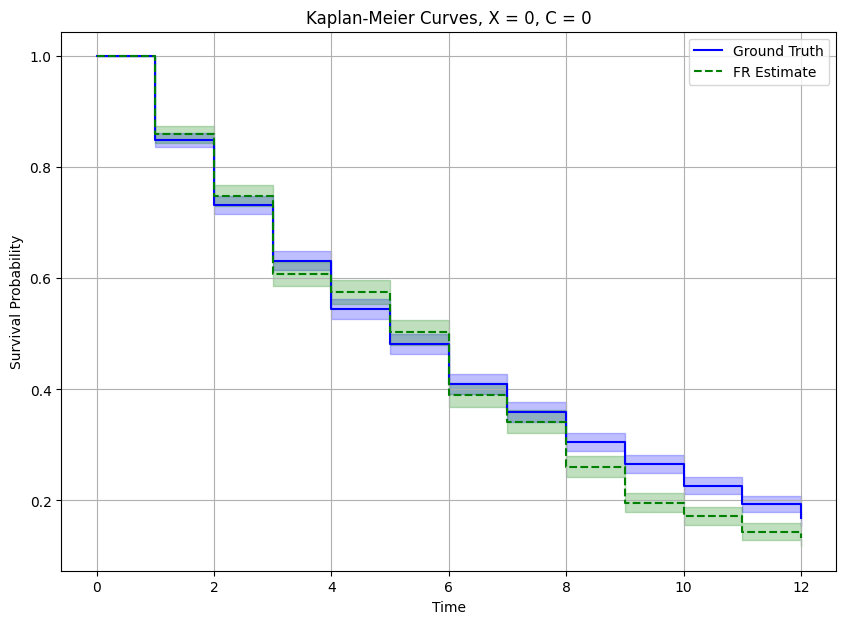

In [31]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

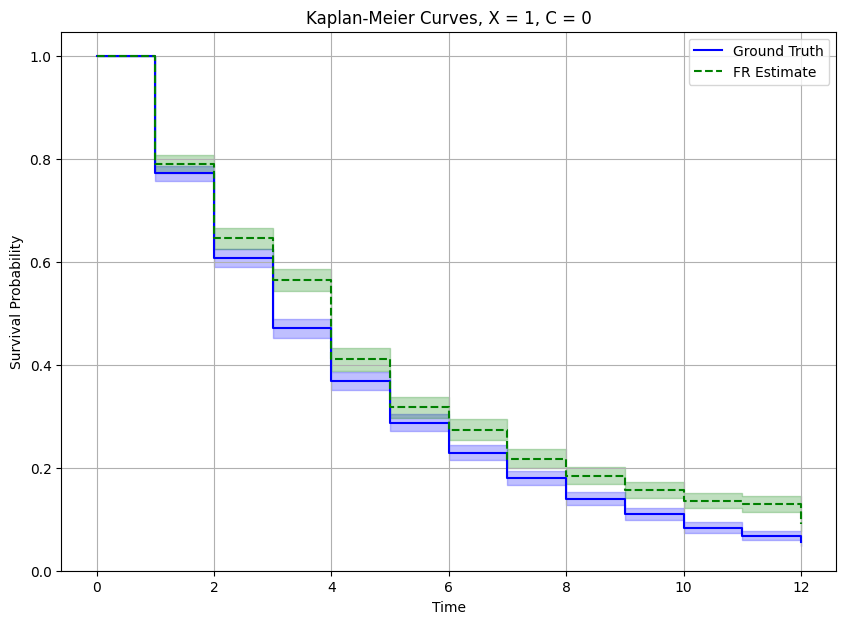

In [32]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 0')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

In [ ]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[1]*12],dtype=torch.int32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model3.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[0]*12],dtype=torch.int32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.15+0.1*C  # mean parameter
mu_x1 = 0.25+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(12) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

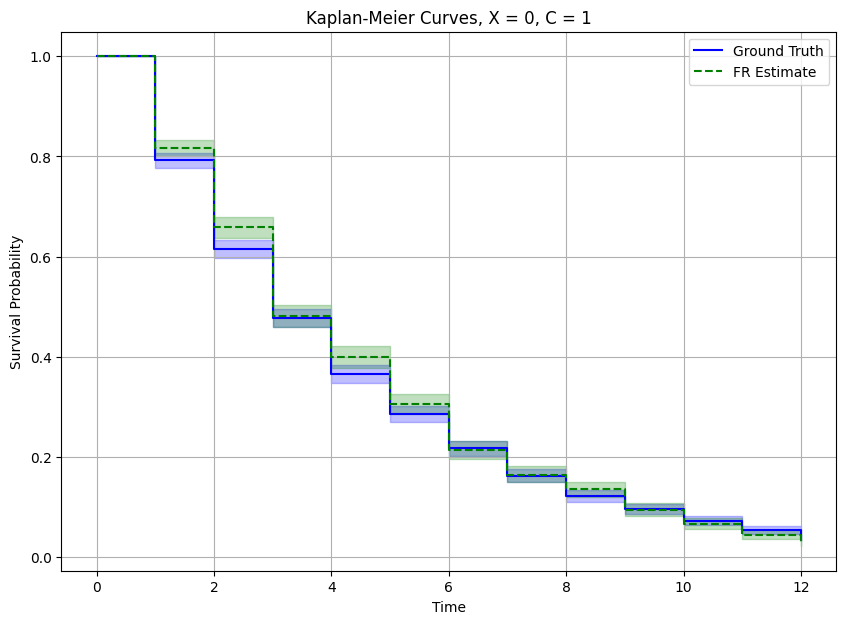

In [34]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 0, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

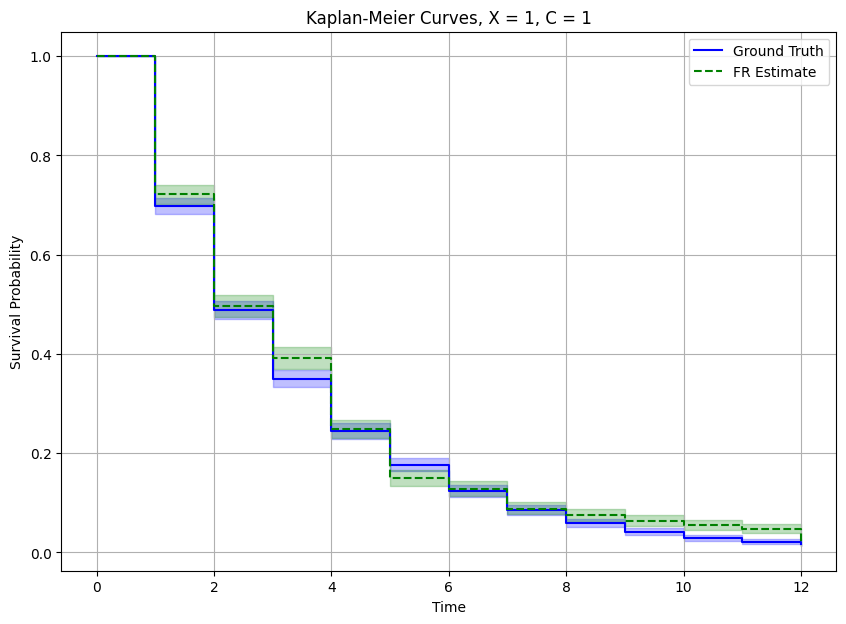

In [35]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

# Setting 4

In [10]:
s,x,z,y = generate_data_survivl(n=5000,T=10, random_seed=42, C_coeff=0.1, setting=3)
s_tr = torch.tensor(s, dtype=torch.int32)
x_tr = torch.tensor(x, dtype=torch.float32)
y_tr = torch.tensor(y, dtype=torch.int32)
z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

model4 = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = False, s_in_predict=True, y_binary=True)
model4.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 4.5349,	loss_y 1.5676, 1.5813, 0.0274,	loss_eta 2.9674, 3.0999, 0.2652, 	marginal_loss 0.2209
Epoch 1: y_sample_mean 0.40077999234199524
Epoch 1: y_sample1_cat.float().mean() 0.5048691630363464
Epoch 200: loss 3.3869,	loss_y 1.2010, 1.6214, 0.8409,	loss_eta 2.1859, 4.0757, 3.7795, 	marginal_loss 0.0130
Epoch 200: y_sample_mean 0.4006200134754181
Epoch 200: y_sample1_cat.float().mean() 0.4281628131866455
Epoch 400: loss 3.2591,	loss_y 1.0653, 1.7619, 1.3932,	loss_eta 2.1939, 4.3773, 4.3669, 	marginal_loss 0.0059
Epoch 400: y_sample_mean 0.4000200033187866
Epoch 400: y_sample1_cat.float().mean() 0.42099055647850037
Epoch 600: loss 3.1929,	loss_y 0.9980, 1.7727, 1.5494,	loss_eta 2.1949, 4.3823, 4.3748, 	marginal_loss 0.0046
Epoch 600: y_sample_mean 0.3980199992656708
Epoch 600: y_sample1_cat.float().mean() 0.41206327080726624
Epoch 800: loss 3.1096,	loss_y 0.9398, 1.7089, 1.5381,	loss_eta 2.1698, 4.3555, 4.3716, 	marginal_loss 0.0027
Epoch 800: y_sample_mean 0.40094000101089

In [24]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=1000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 2.8076,	loss_y 0.6245, 1.1972, 1.1456,	loss_eta 2.1831, 4.3596, 4.3529
Epoch 200: loss 2.8004,	loss_y 0.6109, 1.1789, 1.1361,	loss_eta 2.1895, 4.3547, 4.3303
Epoch 400: loss 2.7673,	loss_y 0.5989, 1.1705, 1.1433,	loss_eta 2.1685, 4.3485, 4.3602
Epoch 600: loss 2.7636,	loss_y 0.5973, 1.1637, 1.1328,	loss_eta 2.1662, 4.3444, 4.3564
Epoch 800: loss 2.7754,	loss_y 0.6052, 1.1593, 1.1082,	loss_eta 2.1702, 4.3368, 4.3331
Epoch 1000: loss 2.7503,	loss_y 0.5784, 1.1272, 1.0976,	loss_eta 2.1719, 4.3612, 4.3784


In [16]:

#torch.manual_seed(42)
C=1

y_x1 = missing_impute(model4.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[3]*10],dtype=torch.float32),sample_size=1000))
y_x1 = y_x1.reshape(1000, 10)
df_x1 = long_to_surv(y_x1)
y_x0 = missing_impute(model4.sample_causal_margin(s=torch.tensor([[C]],dtype=torch.int32), 
                                            x = torch.tensor([[2]*10],dtype=torch.float32),sample_size=1000))
y_x0 = y_x0.reshape(1000, 10)
df_x0 = long_to_surv(y_x0)


mu_x0 = 0.7+0.1*C  # mean parameter
mu_x1 = 1+0.1*C
phi=1

n_samples = 3000
time_step = 1  
max_time = math.ceil(10) 
time_points = np.arange(1, max_time + 1, time_step) 

# x=0
gamma_dist_x0 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x0)
continuous_survival_times = gamma_dist_x0.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x0 = long_to_surv(binary_data)

# x=1
gamma_dist_x1 = torch.distributions.Gamma(concentration=1/phi, rate=mu_x1)
continuous_survival_times = gamma_dist_x1.sample((n_samples,)).numpy()

binary_data = []

for survival_time in continuous_survival_times:
    event_indicator = []
    event_occurred = False
    for t in time_points:
        if not event_occurred:
            if survival_time <= t:
                event_indicator.append(1)
                event_occurred = True
            else:
                event_indicator.append(0)
        else:
            event_indicator.append(-1)
    binary_data.append(event_indicator)

binary_data = np.array(binary_data)
df_binary_x1 = long_to_surv(binary_data)

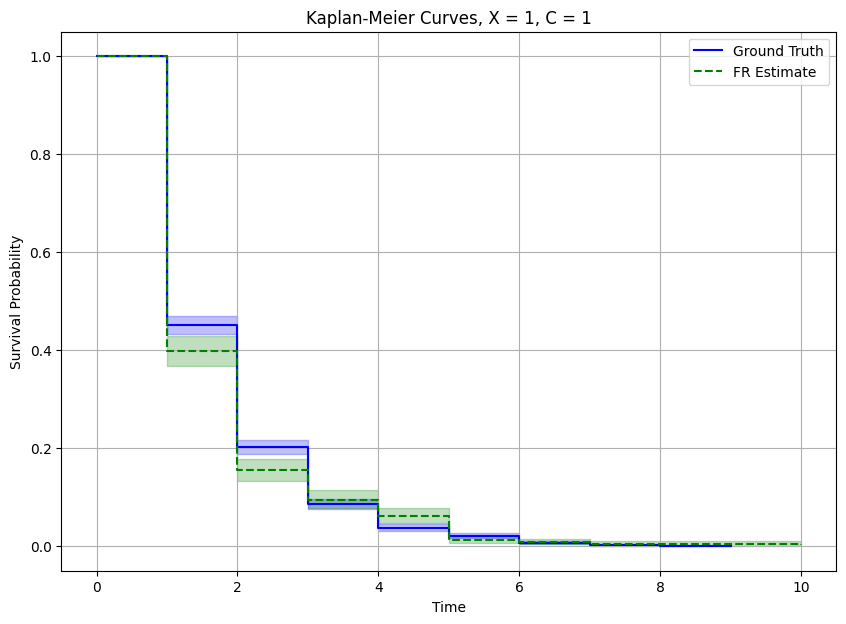

In [17]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x0['time'], event_observed=df_binary_x0['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x0['time'], event_observed=df_x0['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 1, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

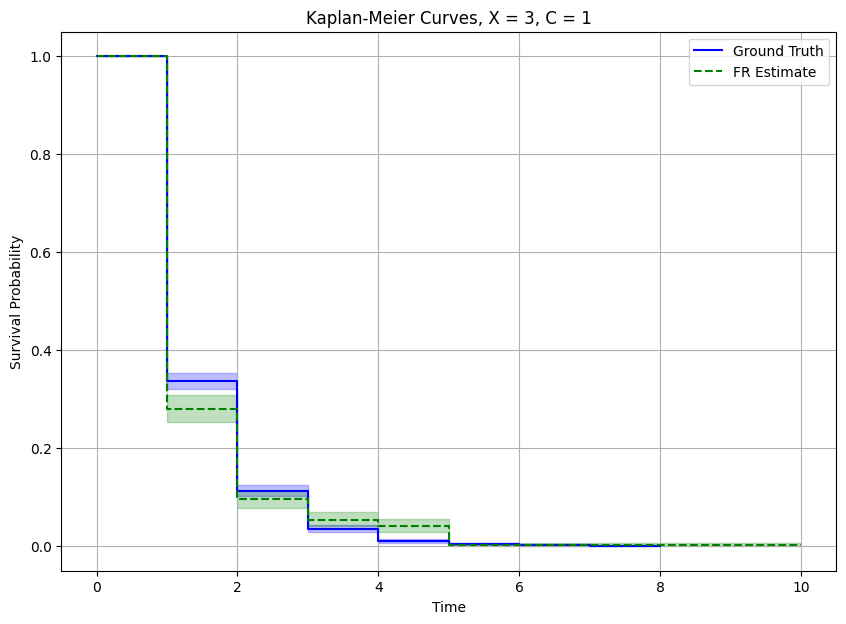

In [18]:
# Initialize KM Fitters
kmf_true = KaplanMeierFitter()
kmf_fr = KaplanMeierFitter()

# Fit the models
kmf_true.fit(durations=df_binary_x1['time'], event_observed=df_binary_x1['event'], label='Ground Truth')
kmf_fr.fit(durations=df_x1['time'], event_observed=df_x1['event'], label='FR Estimate')

# Plot the KM curves
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)

kmf_true.plot_survival_function(ax=ax, ci_show=True, color='blue', linestyle='-')
kmf_fr.plot_survival_function(ax=ax, ci_show=True, color='green', linestyle='--')

plt.title('Kaplan-Meier Curves, X = 3, C = 1')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()


plt.show()

Epoch 1: loss 4.5943,	loss_y 1.5745, 1.5913, 0.0336,	loss_eta 3.0198, 3.1201, 0.2006, 	marginal_loss 0.5329
Epoch 1: y_sample_mean 0.3387666642665863
Epoch 1: y_sample1_cat.float().mean() 0.5083307027816772
Epoch 500: loss 3.2272,	loss_y 1.0451, 1.7234, 1.3566,	loss_eta 2.1821, 4.3763, 4.3884, 	marginal_loss 0.0202
Epoch 500: y_sample_mean 0.3359833359718323
Epoch 500: y_sample1_cat.float().mean() 0.3639950752258301
Epoch 1000: loss 3.1304,	loss_y 0.9549, 1.7287, 1.5476,	loss_eta 2.1755, 4.3697, 4.3884, 	marginal_loss 0.0056
Epoch 1000: y_sample_mean 0.33799999952316284
Epoch 1000: y_sample1_cat.float().mean() 0.3538384735584259
Epoch 1500: loss 3.0370,	loss_y 0.8482, 1.5418, 1.3873,	loss_eta 2.1888, 4.3553, 4.3329, 	marginal_loss 0.0025
Epoch 1500: y_sample_mean 0.3375833332538605
Epoch 1500: y_sample1_cat.float().mean() 0.34599238634109497
Epoch 2000: loss 2.9454,	loss_y 0.7647, 1.4357, 1.3421,	loss_eta 2.1808, 4.3532, 4.3448, 	marginal_loss 0.0015
Epoch 2000: y_sample_mean 0.3389166

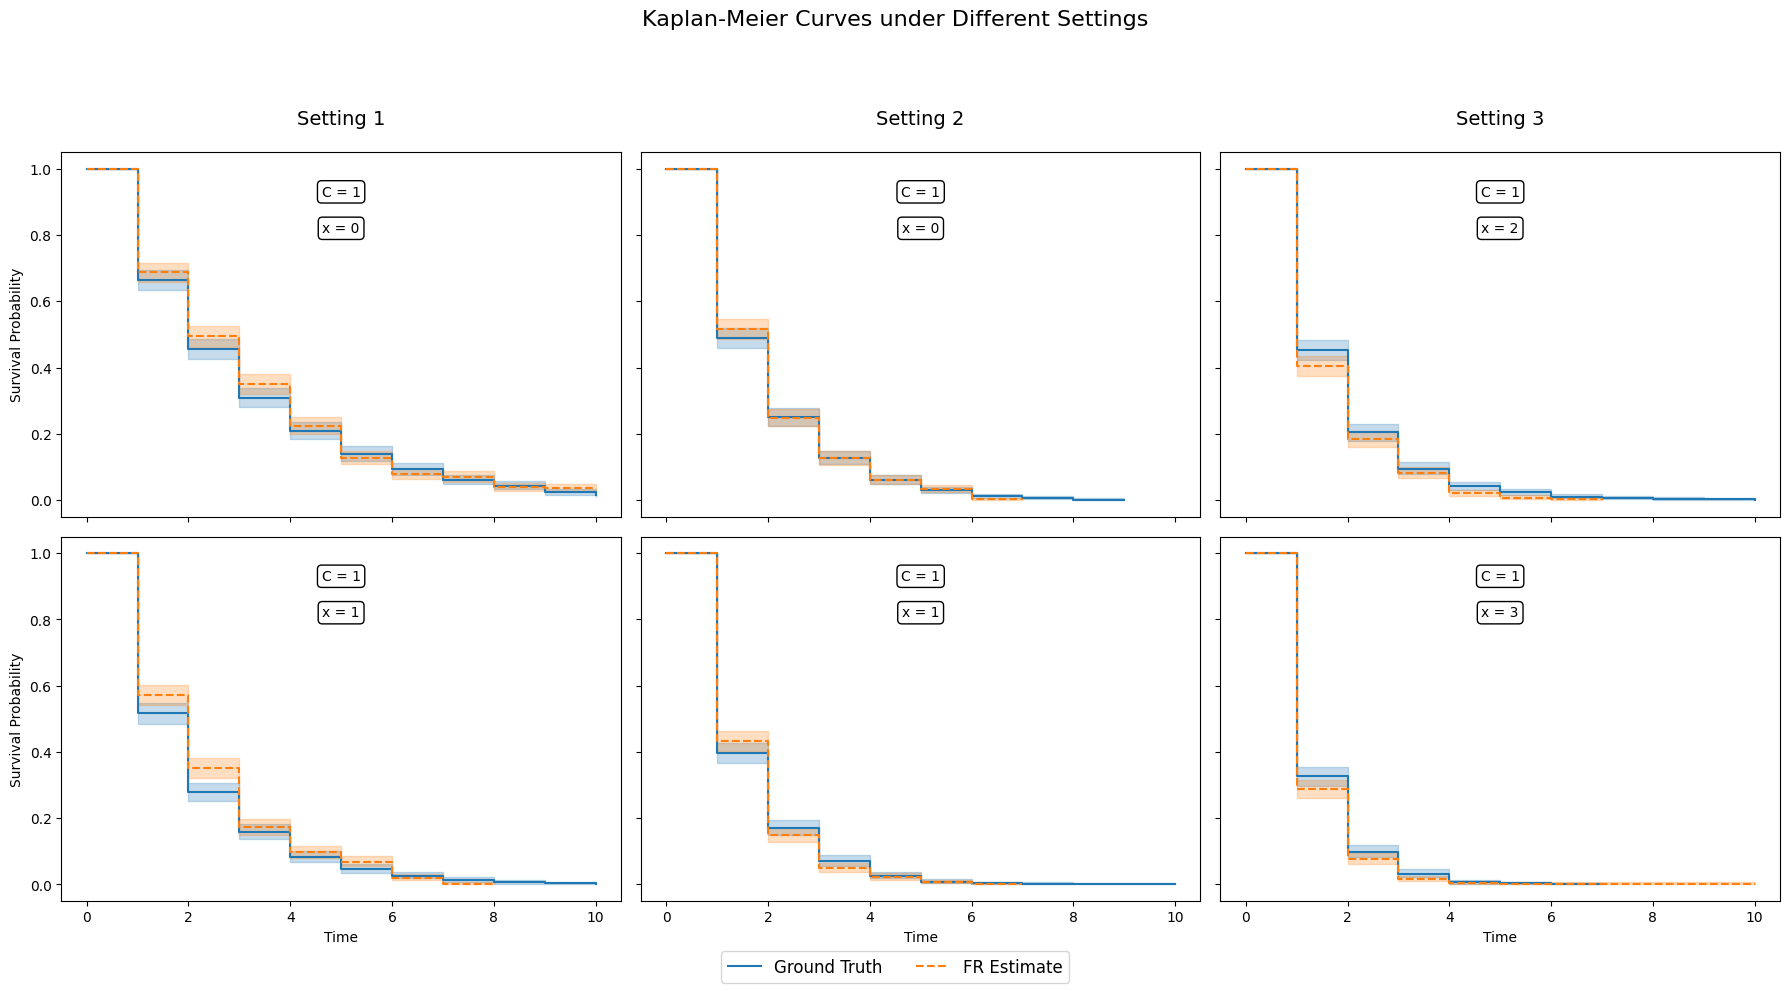

In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def generate_km_data(
    setting, n, seed, C_coeff, C,
    mu0, mu1, x_vals=(0,1),
    train_iters=2000, lr=1e-4,
    T=10, sample_size=1000, phi=1
):
    """
    Generate KM‐data for one setting:
      • setting, n, seed, C_coeff → simulate & fit FR model with train_iters, lr
      • C → confounder value
      • (mu0, mu1) for true Gamma rates at x_vals
      • x_vals → list/tuple of the two x‐values to evaluate
    Returns dict { x_val: (df_true, df_est) }.
    """
    # 1) simulate & train
    s, x, z, y = generate_data_survivl(n=n, T=T,
                                       random_seed=seed,
                                       C_coeff=C_coeff,
                                       setting=setting)
    s_tr = torch.tensor(s, dtype=torch.int32)
    x_tr = torch.tensor(x, dtype=torch.float32)
    y_tr = torch.tensor(y, dtype=torch.int32)
    z_tr = torch.nan_to_num(torch.tensor(z, dtype=torch.float32))

    model = FrengressionSurv(
        x_dim=1, y_dim=1, z_dim=1, T=T, s_dim=1, noise_dim=1,
        num_layer=3, hidden_dim=100, device=device,
        x_binary=True, s_in_predict=True, y_binary=True
    )
    model.train_y(
        s=s_tr, x=x_tr, z=z_tr, y=y_tr,
        num_iters=train_iters, lr=lr, 
        print_every_iter=max(train_iters//4, 1)
    )

    # 2) sample FR & true for each x_val
    max_time = math.ceil(T)
    times = np.arange(1, max_time + 1)
    mus = { x_vals[0]: mu0, x_vals[1]: mu1 }

    out = {}
    for x_val in x_vals:
        # 2a) FR estimate
        x_repeat = torch.tensor([[x_val]*T], dtype=torch.int32)
        y_samps = missing_impute(
            model.sample_causal_margin(
                s=torch.tensor([[C]], dtype=torch.int32),
                x=x_repeat,
                sample_size=sample_size
            )
        )
        df_est = long_to_surv(y_samps.reshape(sample_size, T))

        # 2b) “True” from Gamma
        gamma = torch.distributions.Gamma(
            concentration=1/phi, rate=mus[x_val]
        )
        cont = gamma.sample((sample_size,)).numpy()

        binary = []
        for st in cont:
            ev, happened = [], False
            for t in times:
                if not happened:
                    if st <= t:
                        ev.append(1)
                        happened = True
                    else:
                        ev.append(0)
                else:
                    ev.append(-1)
            binary.append(ev)

        df_true = long_to_surv(np.array(binary))
        out[x_val] = (df_true, df_est)

    return out

# ——— define your settings with per‐setting train_iters ———
settings = [
    # Setting 1: 2000 its
    dict(
      setting=1, n=6000, seed=42, C_coeff=0.1, C=1,
      mu0=0.3+0.1*1, mu1=0.5+0.1*1,
      x_vals=(0,1),
      train_iters=2000, lr=1e-4
    ),
    # Setting 2: 1200 its
    dict(
      setting=2, n=6000, seed=42, C_coeff=0.2, C=1,
      mu0=0.5+0.2*1, mu1=0.7+0.2*1,
      x_vals=(0,1),
      train_iters=1500, lr=1e-4
    ),
    # Setting 3: 4000 its, x in {1,2}
    dict(
      setting=3, n=6000, seed=42, C_coeff=0.1, C=1,
      mu0=0.7+0.1*1, mu1=1+0.1*1,
      x_vals=(2,3),
      train_iters=5000, lr=1e-4
    ),
]

# ——— generate & plot ———
all_data = [generate_km_data(**p) for p in settings]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True,
                         figsize=(18, 10))
fig.suptitle("Kaplan-Meier Curves under Different Settings", fontsize=16, y=0.95)

for col, (params, data) in enumerate(zip(settings, all_data)):
    Cval = params['C']
    for row, x_val in enumerate(params['x_vals']):
        ax = axes[row, col]
        df_true, df_est = data[x_val]

        kmf_t = KaplanMeierFitter().fit(
            df_true['time'], df_true['event'], label='Ground Truth'
        )
        kmf_f = KaplanMeierFitter().fit(
            df_est['time'], df_est['event'], label='Simulation from Frengression'
        )

        kmf_t.plot_survival_function(ax=ax, ci_show=True, linestyle='-')
        kmf_f.plot_survival_function(ax=ax, ci_show=True, linestyle='--')

        # remove the small‐subplot legend
        if ax.get_legend() is not None:
            ax.get_legend().remove()

        # annotate C and x
        ax.text(0.5, 0.88, f"C = {Cval}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))
        ax.text(0.5, 0.78, rf"$\bar{{x}}_T$ = {x_val}",
                transform=ax.transAxes, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white"))

        if row == 1:
            ax.set_xlabel("Time")
        if col == 0:
            ax.set_ylabel("Survival Probability")

    axes[0, col].set_title(f"Setting {col+1}", pad=20, fontsize=14)

# single legend at lower center
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [9]:
import dltmle
import numpy as np
W, L, A, C, Y = dltmle.example_dgp(np.random.default_rng(0), 10, 5)

# hparams_candidates = {
#     'dim_emb': [16],
#     'dim_emb_time': [ 8],
#     'dim_emb_type': [ 8],
#     'hidden_size': [16],
#     'num_layers': [ 4],
#     'nhead': [4],
#     'dropout': [0],
#     'learning_rate': [1e-3],
#     'alpha': [0.05],
#     'beta': [0.05],
#     'max_epochs': [100],
#     'batch_size': [1000],
# }

# hparams = dltmle.tune(0, hparams_candidates, W, L, A, C, Y)

# psi_0 = dltmle.fit(0, hparams, W, L, A, C, Y, np.zeros_like(A))
# psi_1 = dltmle.fit(0, hparams, W, L, A, C, Y, np.ones_like(A))


In [12]:
W

array([[ 0.12573022],
       [-0.13210486],
       [ 0.64042265],
       [ 0.10490012],
       [-0.53566937],
       [ 0.36159505],
       [ 1.30400005],
       [ 0.94708096],
       [-0.70373524],
       [-1.26542147]])

In [12]:
psi_0

estimate: 0.328, SE: 0.043, 95% CI: (0.243, 0.413)

In [15]:
psi_1

estimate: 0.069, SE: 0.010, 95% CI: (0.049, 0.090)

In [ ]:
x_tensor=torch.S

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
x_tensor  = torch.tensor(A.reshape(1000,10),dtype=torch.int32)
y_tensor = torch.tensor(Y.reshape(1000,10), dtype=torch.int32)
z_tensor = torch.tensor(L.reshape(1000,10),dtype=torch.float32)
s_tensor = torch.tensor(W, dtype=torch.float32)

In [41]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = s_tensor.shape[1], noise_dim=100, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 1673.0052,	loss_y 1.5786, 1.6156, 0.0740,	loss_eta 2.9635, 3.1148, 0.3026, 	marginal_loss 1668.4631
Epoch 1: y_sample_mean 0.019999999552965164
Epoch 1: y_sample1_cat.float().mean() 0.5108325481414795
Epoch 1000: loss 3.8092,	loss_y 0.1942, 0.2488, 0.1092,	loss_eta 2.2180, 4.4746, 4.5132, 	marginal_loss 1.3970
Epoch 1000: y_sample_mean 0.02070000022649765
Epoch 1000: y_sample1_cat.float().mean() 0.007372068706899881
Epoch 2000: loss 2.4547,	loss_y 0.2026, 0.3071, 0.2090,	loss_eta 2.2166, 4.4243, 4.4154, 	marginal_loss 0.0355
Epoch 2000: y_sample_mean 0.02070000022649765
Epoch 2000: y_sample1_cat.float().mean() 0.01952884905040264
Epoch 3000: loss 2.4133,	loss_y 0.2036, 0.3131, 0.2188,	loss_eta 2.1966, 4.4142, 4.4352, 	marginal_loss 0.0130
Epoch 3000: y_sample_mean 0.020600000396370888
Epoch 3000: y_sample1_cat.float().mean() 0.019642019644379616
Epoch 4000: loss 2.3999,	loss_y 0.1994, 0.3078, 0.2169,	loss_eta 2.1649, 4.4224, 4.5150, 	marginal_loss 0.0357
Epoch 4000: y_sam

In [42]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 5000
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)
N0, T = s_tensor[(x_tensor[:,0]==0),:].shape
N1, T = s_tensor[(x_tensor[:,0]==1),:].shape
# Prepare “pure” control/treatment arms
x_control = torch.zeros((N0, T), dtype=torch.int32)
x_treat   = torch.ones((N1, T), dtype=torch.int32)

control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [43]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 5000 sims: 0.021–0.047
 Treatment arm event‐rate over 5000 sims: 0.012–0.037
0.033265631071291865
0.024436288774665443


## Comparison with dltmle

In [46]:
import numpy as np

def missing_impute_np(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    """
    Impute values *after* the first positive event in each sequence to `missing_to_num`.
    
    Parameters
    ----------
    y : np.ndarray, shape (n_obs, timesteps)
        Primary sequence data.
    x : np.ndarray or None, shape (n_obs, timesteps * x_dim)
        Optional time-varying covariates.
    z : np.ndarray or None, shape (n_obs, timesteps * z_dim)
        Optional static or other covariates.
    x_dim : int
        Number of features per timestep in x.
    z_dim : int
        Number of features per timestep in z.
    missing_to_num : scalar
        Value to assign after the first event.
    
    Returns
    -------
    If x and z are both None:
        y_out : np.ndarray, same shape as y
    Otherwise:
        x_out : np.ndarray or None
        z_out : np.ndarray or None
        y_out : np.ndarray
    """
    # 1) Copy and identify events
    y_out = np.copy(y)
    event_indicator = (y_out > 0).astype(int)             # shape (n_obs, timesteps)
    
    # 2) Cumulative count of events, shifted right by one
    cumsum = np.cumsum(event_indicator, axis=1)           # shape (n_obs, timesteps)
    c_shifted = np.zeros_like(cumsum)
    c_shifted[:, 1:] = cumsum[:, :-1]
    
    # 3) Mask all timesteps after the first event
    mask = c_shifted > 0                                   # True for “after first event”
    y_out[mask] = missing_to_num
    
    # If no x/z, just return the imputed y
    if x is None and z is None:
        return y_out
    
    n_obs, timesteps = y.shape
    x_out = None
    z_out = None
    
    # 4) Process x (if provided)
    if x is not None:
        x_arr = np.copy(x).reshape(n_obs, timesteps, x_dim)
        mask_x = mask[..., np.newaxis]                    # shape (n_obs, timesteps, 1)
        x_arr[mask_x] = missing_to_num
        x_out = x_arr.reshape(n_obs, timesteps * x_dim)
    
    # 5) Process z (if provided)
    if z is not None:
        z_arr = np.copy(z).reshape(n_obs, timesteps, z_dim)
        mask_z = mask[..., np.newaxis]
        z_arr[mask_z] = missing_to_num
        z_out = z_arr.reshape(n_obs, timesteps * z_dim)
    
    return x_out, z_out, y_out


In [61]:
import dltmle
import numpy as np


W,A,L,Y = generate_data_survivl(n=5000,T=5, random_seed=2025, C_coeff=0.1, setting = 1)

A, L, Y = missing_impute_np(y=Y, x=A, z=L, x_dim=1, z_dim=1, missing_to_num=1)

A=A.reshape(A.shape[0],A.shape[1],1)
L=L.reshape(L.shape[0],L.shape[1],1)
Y=Y.reshape(Y.shape[0],Y.shape[1],1)

C = np.zeros_like(Y)

hparams_candidates = {
    'dim_emb': [8, 16],
    'dim_emb_time': [4, 8],
    'dim_emb_type': [4, 8],
    'hidden_size': [8, 16, 32],
    'num_layers': [1, 2, 4],
    'nhead': [2, 4],
    'dropout': [0, 0.1, 0.2],
    'learning_rate': [1e-3, 5e-4, 1e-4, 5e-5],
    'alpha': [0.05, 0.1, 0.5, 1],
    'beta': [0.05, 0.1, 0.5, 1],
    'max_epochs': [100],
    'batch_size': [64],
}

hparams = dltmle.tune(0, hparams_candidates, W, L, A, C, Y, n_trials=10)

[I 2025-04-30 17:57:55,881] A new study created in memory with name: no-name-afc6753c-3b8b-4469-bf4f-dc96ab06e3d5
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     | train
3  | emb_C             | Linear                  | 16     | train
4  | emb_Y             | Linear                  | 16     | train
5  | emb_time          | Sequential              | 76     | train
6  | transformer_layer | TransformerEncoderLayer | 2.1 K  | train
7  | transf

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:01:40,081] Trial 0 finished with value: 2.8917269706726074 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.1, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.8917269706726074.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:02:40,955] Trial 1 finished with value: 2.9760704040527344 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 8, 'num_layers': 1, 'nhead': 2, 'dropout': 0, 'learning_rate': 0.0005, 'alpha': 0.5, 'beta': 0.5, 'max_epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.8917269706726074.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:04:05,363] Trial 2 finished with value: 2.7985000610351562 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 16, 'num_layers': 1, 'nhead': 2, 'dropout': 0.2, 'learning_rate': 0.001, 'alpha': 0.1, 'beta': 0.5, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:06:32,143] Trial 3 finished with value: 2.9012269973754883 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 16, 'num_layers': 2, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 5e-05, 'alpha': 0.5, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:07:53,766] Trial 4 finished with value: 2.943876266479492 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 32, 'num_layers': 2, 'nhead': 2, 'dropout': 0, 'learning_rate': 5e-05, 'alpha': 0.05, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:10:19,795] Trial 5 finished with value: 2.87150239944458 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 8, 'hidden_size': 16, 'num_layers': 2, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.5, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:12:07,099] Trial 6 finished with value: 2.9097139835357666 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 32, 'num_layers': 2, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'alpha': 1, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:15:04,636] Trial 7 finished with value: 2.9094386100769043 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 5e-05, 'alpha': 0.5, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:16:38,446] Trial 8 finished with value: 2.885042428970337 and parameters: {'dim_emb': 8, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 4, 'dropout': 0, 'learning_rate': 0.0005, 'alpha': 0.05, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 18:19:34,868] Trial 9 finished with value: 2.9262301921844482 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 32, 'num_layers': 4, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.05, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 2 with value: 2.7985000610351562.


In [62]:
psi_0 = dltmle.fit(0, hparams, W, L, A, C, Y, np.zeros_like(A))
psi_1 = dltmle.fit(0, hparams, W, L, A, C, Y, np.ones_like(A))

print('mean counterfactual outcome under a = 0', psi_0)
print('mean counterfactual outcome under a = 1', psi_1)
print('ATE (risk difference)', psi_1 - psi_0)
print('risk ratio', psi_1 / psi_0)
print('odds ratio', (psi_1 / (1 - psi_1)) / (psi_0 / (1 - psi_0)))

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | train
3  | emb_C             | Linear                  | 32     | train
4  | emb_Y             | Linear                  | 32     | train
5  | emb_time          | Sequential              | 76     | train
6  | transformer_layer | TransformerEncoderLayer | 5.4 K  | train
7  | transformer       | TransformerEncoder      | 5.4 K  | train
8  | logit_Q           | Linear                  | 33     |

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | train
3  | emb_C             | Linear                  | 32     | train
4  | emb_Y             | Linear                  | 32     | train
5  | emb_time          | Sequential              | 76     | train
6  | transformer_layer | TransformerEncoderLayer | 5.4 K  | train
7  | transformer       | TransformerEncoder      | 5.4 K  | train
8  | logit_Q           | Linear                  | 33     |

est:  0.8086375
CI:  0.7720983224145813 0.845176677203949
se:  0.018642437446267274
E_n[IC] = -0.033917274326086044
PnIC/√PnIC2 = 0.02572961260507478
Q_l_star [0.80863747 0.81908334 0.71930513 0.62054562 0.49878344 0.35647471]
Q_a_star [0.80863747 0.80500101 0.73107095 0.6390549  0.53068593 0.34961998]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

est:  0.9382791
CI:  0.903375203506959 0.9731829811167593
se:  0.017808106533112322
E_n[IC] = 0.00687995832413435
PnIC/√PnIC2 = 0.0054636523835148035
Q_l_star [0.93827911 0.93621913 0.88658017 0.80163858 0.65115279 0.36158982]
Q_a_star [0.93827911 0.93176776 0.88363135 0.7920032  0.64451791 0.34961998]
mean counterfactual outcome under a = 0 estimate: 0.809, SE: 0.019, 95% CI: (0.772, 0.845)
mean counterfactual outcome under a = 1 estimate: 0.938, SE: 0.018, 95% CI: (0.903, 0.973)
ATE (risk difference) estimate: 0.130, SE: 0.026, 95% CI: (0.079, 0.180)
risk ratio estimate: 1.160, SE: 0.035, 95% CI: (1.092, 1.228)
odds ratio estimate: 3.598, SE: 1.006, 95% CI: (1.626, 5.569)


In [58]:
import dltmle
import numpy as np


W,A,L,Y = generate_data_survivl(n=5000,T=5, random_seed=2025, C_coeff=0.2, setting = 2)

A, L, Y = missing_impute_np(y=Y, x=A, z=L, x_dim=1, z_dim=1, missing_to_num=1)

A=A.reshape(A.shape[0],A.shape[1],1)
L=L.reshape(L.shape[0],L.shape[1],1)
Y=Y.reshape(Y.shape[0],Y.shape[1],1)

C = np.zeros_like(Y)

hparams_candidates = {
    'dim_emb': [8, 16],
    'dim_emb_time': [4, 8],
    'dim_emb_type': [4, 8],
    'hidden_size': [8, 16, 32],
    'num_layers': [1, 2, 4],
    'nhead': [2, 4],
    'dropout': [0, 0.1, 0.2],
    'learning_rate': [1e-3, 5e-4, 1e-4, 5e-5],
    'alpha': [0.05, 0.1, 0.5, 1],
    'beta': [0.05, 0.1, 0.5, 1],
    'max_epochs': [100],
    'batch_size': [64],
}

hparams = dltmle.tune(0, hparams_candidates, W, L, A, C, Y, n_trials=10)

[I 2025-04-30 17:24:11,405] A new study created in memory with name: no-name-d1d20508-9f70-4e77-87ff-904eadf8ea81
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     | train
3  | emb_C             | Linear                  | 16     | train
4  | emb_Y             | Linear                  | 16     | train
5  | emb_time          | Sequential              | 76     | train
6  | transformer_layer | TransformerEncoderLayer | 2.1 K  | train
7  | transf

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:27:50,799] Trial 0 finished with value: 1.6057827472686768 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.1, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.6057827472686768.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:28:49,448] Trial 1 finished with value: 1.4677531719207764 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 8, 'num_layers': 1, 'nhead': 2, 'dropout': 0, 'learning_rate': 0.0005, 'alpha': 0.5, 'beta': 0.5, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:30:07,523] Trial 2 finished with value: 1.4875200986862183 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 16, 'num_layers': 1, 'nhead': 2, 'dropout': 0.2, 'learning_rate': 0.001, 'alpha': 0.1, 'beta': 0.5, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:32:24,539] Trial 3 finished with value: 1.5098001956939697 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 16, 'num_layers': 2, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 5e-05, 'alpha': 0.5, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:33:38,801] Trial 4 finished with value: 1.5467677116394043 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 32, 'num_layers': 2, 'nhead': 2, 'dropout': 0, 'learning_rate': 5e-05, 'alpha': 0.05, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:35:58,833] Trial 5 finished with value: 1.4860697984695435 and parameters: {'dim_emb': 16, 'dim_emb_time': 4, 'dim_emb_type': 8, 'hidden_size': 16, 'num_layers': 2, 'nhead': 4, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.5, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:37:41,682] Trial 6 finished with value: 1.5093024969100952 and parameters: {'dim_emb': 8, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 32, 'num_layers': 2, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'alpha': 1, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:40:35,771] Trial 7 finished with value: 1.5000571012496948 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 5e-05, 'alpha': 0.5, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 1 with value: 1.4677531719207764.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:42:10,929] Trial 8 finished with value: 1.4543707370758057 and parameters: {'dim_emb': 8, 'dim_emb_time': 4, 'dim_emb_type': 4, 'hidden_size': 8, 'num_layers': 4, 'nhead': 4, 'dropout': 0, 'learning_rate': 0.0005, 'alpha': 0.05, 'beta': 1, 'max_epochs': 100, 'batch_size': 64}. Best is trial 8 with value: 1.4543707370758057.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 32     | train
1  | emb_L             | Linear                  | 32     | train
2  | emb_A             | Linear                  | 32     | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2025-04-30 17:45:05,629] Trial 9 finished with value: 1.5052344799041748 and parameters: {'dim_emb': 16, 'dim_emb_time': 8, 'dim_emb_type': 8, 'hidden_size': 32, 'num_layers': 4, 'nhead': 2, 'dropout': 0.1, 'learning_rate': 0.0005, 'alpha': 0.05, 'beta': 0.05, 'max_epochs': 100, 'batch_size': 64}. Best is trial 8 with value: 1.4543707370758057.


In [59]:
psi_0 = dltmle.fit(0, hparams, W, L, A, C, Y, np.zeros_like(A))
psi_1 = dltmle.fit(0, hparams, W, L, A, C, Y, np.ones_like(A))

print('mean counterfactual outcome under a = 0', psi_0)
print('mean counterfactual outcome under a = 1', psi_1)
print('ATE (risk difference)', psi_1 - psi_0)
print('risk ratio', psi_1 / psi_0)
print('odds ratio', (psi_1 / (1 - psi_1)) / (psi_0 / (1 - psi_0)))

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     | train
3  | emb_C             | Linear                  | 16     | train
4  | emb_Y             | Linear                  | 16     | train
5  | emb_time          | Sequential              | 22     | train
6  | transformer_layer | TransformerEncoderLayer | 1.4 K  | train
7  | transformer       | TransformerEncoder      | 5.7 K  | train
8  | logit_Q           | Linear                  | 17     |

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name              | Type                    | Params | Mode 
-----------------------------------------------------------------------
0  | emb_W             | Linear                  | 16     | train
1  | emb_L             | Linear                  | 16     | train
2  | emb_A             | Linear                  | 16     | train
3  | emb_C             | Linear                  | 16     | train
4  | emb_Y             | Linear                  | 16     | train
5  | emb_time          | Sequential              | 22     | train
6  | transformer_layer | TransformerEncoderLayer | 1.4 K  | train
7  | transformer       | TransformerEncoder      | 5.7 K  | train
8  | logit_Q           | Linear                  | 17     |

est:  0.9606577
CI:  0.9472462630125236 0.9740691685823251
se:  0.006842577951479944
E_n[IC] = -2.4413680876023136e-05
PnIC/√PnIC2 = 5.045782283686386e-05
Q_l_star [0.96065772 0.96350416 0.92151541 0.83678205 0.69087134 0.4614941 ]
Q_a_star [0.96065772 0.96031451 0.91598723 0.84083911 0.7137016  0.51792829]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: |          | 0/? [00:00<?, ?it/s]

est:  0.9880691
CI:  0.9741997537926008 1.001938480345888
se:  0.0070762057533895655
E_n[IC] = -0.0025416931603103876
PnIC/√PnIC2 = 0.005079695339525829
Q_l_star [0.98806906 0.98669313 0.96903183 0.93110414 0.82585624 0.5203395 ]
Q_a_star [0.98806906 0.98635323 0.96852333 0.93012038 0.83514709 0.51792829]
mean counterfactual outcome under a = 0 estimate: 0.961, SE: 0.007, 95% CI: (0.947, 0.974)
mean counterfactual outcome under a = 1 estimate: 0.988, SE: 0.007, 95% CI: (0.974, 1.002)
ATE (risk difference) estimate: 0.027, SE: 0.010, 95% CI: (0.008, 0.047)
risk ratio estimate: 1.029, SE: 0.010, 95% CI: (1.008, 1.049)
odds ratio estimate: 3.392, SE: 2.065, 95% CI: (-0.655, 7.439)
